In [2]:
%load_ext rpy2.ipython

In [4]:
%%R
library(readr)
library(dplyr)
library(phyloseq)
library(ggplot2)

In [ ]:
%%R
otu_tab = read_csv("data/EC_table.noMC.csv") %>% {
    rownames(.) = .$seq_id
    .
    } %>%
    select(-seq_id) %>%
    as.matrix %>%
    otu_table(taxa_are_rows = TRUE)

tax_tab = read_csv("data/tax_table.csv") %>% {
    rownames(.) = .$seq_id
    .
    } %>%
    select(-seq_id) %>%
    as.matrix %>%
    tax_table

sample_tab = read_csv("data/sample_data.csv") %>% {
    rownames(.) = .$sample
    .
    } %>%
    select(-sample) %>%
    data.frame %>%
    sample_data

tree = phy_tree(ape::read.tree("data/variants.tree"))

ps = phyloseq(otu_tab, tax_tab, sample_tab, tree) %>%
    prune_samples((sampleSums(.) > 1000)& 
                  (sample_data(.)$star == "star"), .) %>%
    transform_sample_counts(function(x) x / sum(x))

ps2 = phyloseq(otu_tab, tax_tab, sample_tab, tree) %>%
    prune_samples((sampleSums(.) > 1000)& 
                  (sample_data(.)$star %in% c("star", "W")), .) %>%
    transform_sample_counts(function(x) x / sum(x))  
        
ps2        

### Network Analysis

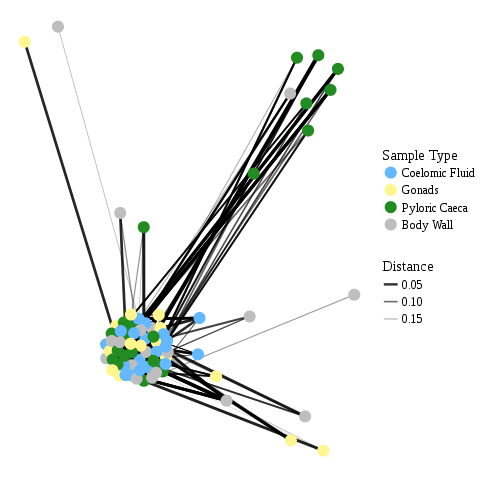

In [42]:
%%R

sampletype = c(
                    `PC` = "Pyloric Caeca",
                    `G` = "Gonads",
                    `CF` = "Coelomic Fluid",
                    `TF` = "Body Wall",
                    `W` = "Sea Water",
                    `S` = "Sediment",
                    `Env` = "Enviromental",
                    `star` = "Sea Star")

p = plot_net(ps, dist.wunif, maxdist = 0.2, color = "Sample.Type") + labs(color = "Sample Type")

p = p + scale_colour_manual(labels = sampletype,
                              values = c("PC" = "forestgreen",
                                       "G" = "khaki1",
                                       "CF" = "steelblue1",
                                       "TF" = "grey",
                                       "S" = "red",
                                       "W" = "darkmagenta"))

p = p + theme(legend.key = element_blank(),
                           legend.margin = unit(1, "cm"),
                           text=element_text(size=15, color="black", family="Times New Roman"))
p

### Creating distance values

In [ ]:
%%R
dist.wunif = distance(ps, method = "wunifrac", type = "samples")

In [222]:
%%R
dist.wunif2 = distance(ps2, method = "wunifrac", type = "samples")

In [316]:
%%R
dist.unif = distance(ps, method = "unifrac", type = "samples")

In [515]:
%%R
dist.bray = distance(ps, method = "bray", type = "samples")

In [585]:
%%R
dist.bray2 = distance(ps2, method = "bray", type = "samples")

### Calculating NMDS values

In [ ]:
%%R
dist.wunif.nmds = metaMDS(dist.wunif,autotransform=F,k=2,trymax=50)
dist.wunif.nmds

In [ ]:
%%R
dist.wunif.nmds2 = metaMDS(dist.wunif2,autotransform=F,k=2,trymax=50)
dist.wunif.nmds2

In [ ]:
%%R
dist.bray.nmds = metaMDS(dist.bray,autotransform=F,k=2,trymax=50)
dist.bray.nmds

In [ ]:
%%R
dist.bray.nmds2 = metaMDS(dist.bray2,autotransform=F,k=2,trymax=50)
dist.bray.nmds2

### Creating variances from distances grouped by sample type

In [14]:
%%R
beta.disp.wunif = betadisper(dist.wunif,group = sample_data(ps)$Sample.Type)
beta.disp.wunif = beta.disp.wunif$distances
beta.disp.wunif = data.frame(d = beta.disp.wunif, Sample = names(beta.disp.wunif))
beta.disp.wunif = beta.disp.wunif %>%
   left_join(sample_tab %>% add_rownames("Sample"))

In [15]:
%%R
summary(beta.disp.wunif$d)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01240 0.04801 0.07735 0.13600 0.19110 0.49030 


In [247]:
%%R
beta.disp.wunif2 = betadisper(dist.wunif2,group = sample_data(ps2)$star)
beta.disp.wunif2 = beta.disp.wunif2$distances
beta.disp.wunif2 = data.frame(d = beta.disp.wunif2, Sample = names(beta.disp.wunif2))
beta.disp.wunif2 = beta.disp.wunif2 %>%
   left_join(sample_tab %>% add_rownames("Sample"))

In [609]:
%%R
beta.disp.bray = betadisper(dist.bray, group = sample_data(ps)$Sample.Type)
beta.disp.bray = beta.disp.bray$distances
beta.disp.bray = data.frame(d = beta.disp.bray, Sample = names(beta.disp.bray))
beta.disp.bray = beta.disp.bray %>%
   left_join(sample_tab %>% add_rownames("Sample"))

In [610]:
%%R
beta.disp.bray2 = betadisper(dist.bray2, group = sample_data(ps2)$Sample.Type)
beta.disp.bray2 = beta.disp.bray2$distances
beta.disp.bray2 = data.frame(d = beta.disp.bray2, Sample = names(beta.disp.bray2))
beta.disp.bray2 = beta.disp.bray2 %>%
   left_join(sample_tab %>% add_rownames("Sample"))

### Plotting Ordinations

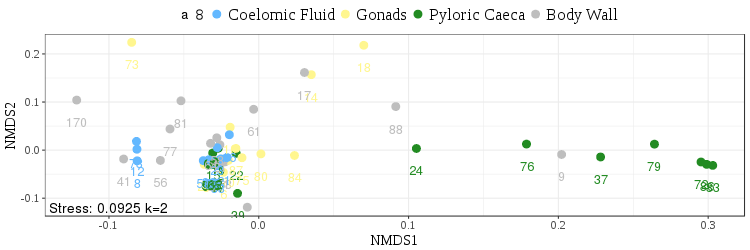

In [205]:
%%R -w 750 -h 250
sampletype = c(
                    `PC` = "Pyloric Caeca",
                    `G` = "Gonads",
                    `CF` = "Coelomic Fluid",
                    `TF` = "Body Wall",
                    `W` = "Sea Water",
                    `S` = "Sediment",
                    `Env` = "Enviromental",
                    `star` = "Sea Star")

p = plot_ordination(ps2, dist.wunif.nmds2, color ="Sample.Type")

p = p + geom_point(size=3.5)

p = p + geom_text(mapping = aes(label = Sample_number,size = 8,vjust=3))

p = p + theme_bw() + theme(legend.key = element_blank(),
                           legend.position = "top",
                           legend.margin = unit(0, "cm"),
                           text=element_text(size=14, color="black", family="Times New Roman"),
                           legend.text = element_text(size=17),
                           legend.title = element_blank())

p = p + scale_colour_manual(labels = sampletype,
                              values = c("PC" = "forestgreen",
                                       "G" = "khaki1",
                                       "CF" = "steelblue1",
                                       "TF" = "grey"))

p = p + annotate("text", label = "Stress: 0.0925 k=2", x = -0.1, y = -0.12, size = 5, colour = "black")

p

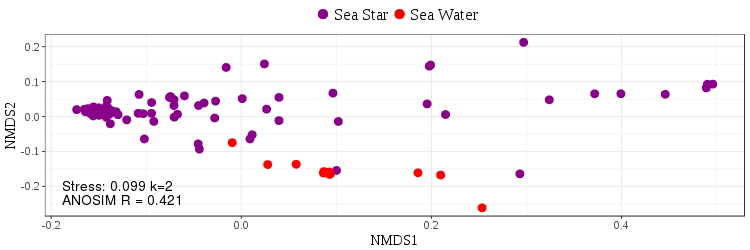

In [245]:
%%R -w 750 -h 250
sampletype = c(
                    `W` = "Sea Water",
                    `star` = "Sea Star")

p = plot_ordination(ps2, dist.wunif.nmds2, color ="star")

p = p + geom_point(size=3.5)


p = p + theme_bw() + theme(legend.key = element_blank(),
                           legend.position = "top",
                           legend.margin = unit(0, "cm"),
                           text=element_text(size=14, color="black", family="Times New Roman"),
                           legend.text = element_text(size=17),
                           legend.title = element_blank())

p = p + guides(colour = guide_legend(override.aes = list(size=4,linetype=0)))

p = p + scale_colour_manual(labels = sampletype,
                             values = c("W" = "red","star" = "darkmagenta"))

p = p + annotate("text", label = "Stress: 0.099 k=2", x = -0.13, y = -0.2, size = 5, colour = "black")

p = p + annotate("text", label = "ANOSIM R = 0.421 ", x = -0.123, y = -0.24, size = 5, colour = "black")

p

### Plotting variance around centroids for different distances measures

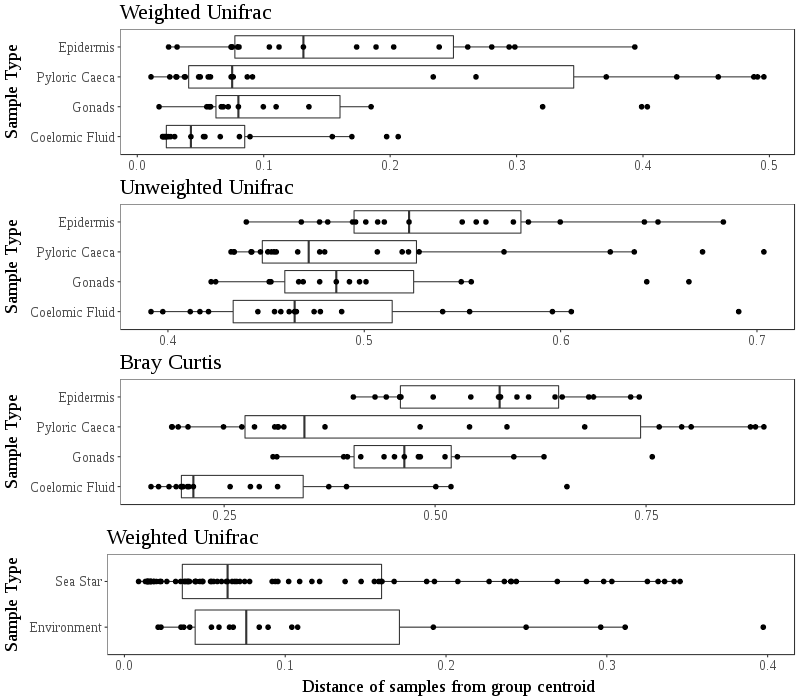

In [200]:
%%R -h 700 -w 800

## plot 1

p = ggplot(beta.disp.wunif, aes(x = Sample.Type, y = d)) + ggtitle("Weighted Unifrac")

p = p + geom_boxplot() + ylab("Distance of samples from group centroid ") + xlab("Sample Type") + coord_flip()

p = p + geom_point(size = 2) + labs(color = "Genus Species & Environmental")

p = p + theme_bw() + theme(text=element_text(size=18, color="black",family = "Times New Roman"),
                           legend.key = element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(),
                           legend.position="none",
                           axis.title.x=element_blank(),
                           axis.title.y=element_text(margin=margin(0,10,0,0)))

p = p + scale_x_discrete(breaks=c("PC", "G", "TF","CF","W","S"),
                      labels=c("Pyloric Caeca", "Gonads", "Epidermis","Coelomic Fluid",
                               "Sea Water","Sediment"))

p

## plot 2

p2 = ggplot(beta.disp.unif, aes(x = Sample.Type, y = d)) + ggtitle("Unweighted Unifrac")

p2 = p2 + geom_boxplot() + xlab("Sample Type") + coord_flip()

p2 = p2 + geom_point(size = 2) + labs(color = "Genus Species & Environmental")

p2 = p2 + theme_bw() + theme(text=element_text(size=18, color="black",family = "Times New Roman"),
                           legend.key = element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(),
                           legend.position="none",
                           axis.title.x=element_blank(),
                           axis.title.y=element_text(margin=margin(0,10,0,0)))

p2 = p2 + scale_x_discrete(breaks=c("PC", "G", "TF","CF","W","S"),
                      labels=c("Pyloric Caeca", "Gonads", "Epidermis","Coelomic Fluid",
                               "Sea Water","Sediment"))

p2

## plot 3

p3 = ggplot(beta.disp.bray, aes(x = Sample.Type, y = d)) + ggtitle("Bray Curtis")

p3 = p3 + geom_boxplot() + xlab("Sample Type") + coord_flip()

p3 = p3 + geom_point(size = 2) + labs(color = "Genus Species & Environmental")

p3 = p3 + theme_bw() + theme(text=element_text(size=18, color="black",family = "Times New Roman"),
                           legend.key = element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(),
                           legend.position="none",
                           axis.title.x=element_blank(),
                           axis.title.y=element_text(margin=margin(0,10,0,0)))
p3 = p3 + scale_x_discrete(breaks=c("PC", "G", "TF","CF"),
                      labels=c("Pyloric Caeca", "Gonads", "Epidermis","Coelomic Fluid"))

p3

## plot 4

p4 = ggplot(beta.disp.wunif3, aes(x = star, y = d)) + ggtitle("Weighted Unifrac")

p4 = p4 + geom_boxplot() + ylab("Distance of samples from group centroid ") + xlab("Sample Type") + coord_flip()

p4 = p4 + geom_point(size = 2) + labs(color = "Genus Species & Environmental")

p4 = p4 + theme_bw() + theme(text=element_text(size=18, color="black",family = "Times New Roman"),
                           legend.key = element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(),
                           legend.position="none", 
                           axis.title.y=element_text(margin=margin(0,10,0,0)),
                           axis.title.x=element_text(margin=margin(10,0,0,0)))

p4 = p4 + scale_x_discrete(breaks=c("star", "Env"),labels=c("Sea Star", "Environment"))

p4

gridExtra::grid.arrange(p, p2, p3, p4, nrow = 4)

### Plot with NMDS and variation boxplot

In [ ]:
%%R -w 600 -h 450

sampletype = c(
                    `PC` = "Pyloric Caeca",
                    `G` = "Gonads",
                    `CF` = "Coelomic Fluid",
                    `TF` = "Body Wall",
                    `W` = "Sea Water",
                    `S` = "Sediment",
                    `Env` = "Enviromental",
                    `star` = "Sea Star")

p = plot_ordination(ps, dist.wunif.nmds, color ="Sample.Type")

p = p + geom_point(size=2.5)

p = p + theme_bw() + theme(legend.key = element_blank(),
                           legend.position = "top",
                           legend.margin = unit(0, "cm"),
                           text=element_text(size=14, color="black", family="Times New Roman"),
                           legend.text = element_text(size=14),
                           legend.title = element_blank())

p = p + scale_colour_manual(labels = sampletype,
                              values = c("PC" = "forestgreen",
                                       "G" = "khaki1",
                                       "CF" = "steelblue1",
                                       "TF" = "grey"))

p = p + annotate("text", label = "Stress: 0.0986 k=2", x = -0.09, y = 0.18, size = 4, colour = "black")

p

## plot 2

#p2 = plot_ordination(ps2, dist.bray.nmds2,color = "star") 
  
#p2 = p2 + geom_point(size=2.5)

#p2 = p2 + theme_bw() + theme(legend.key = element_blank(),
#                           legend.position = "top",
#                           legend.margin = unit(0, "cm"),
#                           text=element_text(size=12, color="black", family="Times New Roman"),
#                           legend.title = element_blank(),
#                           legend.text = element_text(size=12))
                           #axis.title.y=element_text(margin=margin(0,15,0,0)),
                           #axis.title.x=element_text(margin=margin(10,0,0,0)),

#p2 = p2 + guides(colour = guide_legend(override.aes = list(size=4,linetype=0)))

#p2 = p2 + scale_colour_manual(labels = sampletype,
#                              values = c("Env" = "red","star" = "darkmagenta"))

#p2 = p2 + annotate("text", label = "Stress: 0.088 k=2", x = -0.33, y = 0.45, size = 4, colour = "black")

#p2

## plot 3

p3 = ggplot(beta.disp.wunif, aes(x = Sample.Type, y = d)) + ggtitle("Weighted Unifrac")

p3 = p3 + geom_boxplot() + ylab("Distance of samples from group centroids") + coord_flip()

p3 = p3 + geom_point(size = 2)

p3 = p3 + theme_bw() + theme(text=element_text(size=16, color="black",family = "Times New Roman"),
                           legend.key = element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(),
                           legend.position="none",
                           axis.title.y=element_blank())

p3 = p3 + scale_colour_manual(labels = sampletype,
                              values = c("PC" = "forestgreen",
                                       "G" = "khaki1",
                                       "CF" = "steelblue1",
                                       "TF" = "grey"))

p3 = p3 + scale_x_discrete(breaks=c("PC", "G", "TF","CF"),
                      labels=c("Pyloric Caeca", "Gonads", "Body Wall","Coelomic Fluid"))

#p3

##plot 4

#p4 = ggplot(beta.disp.wunif2, aes(x = star, y = d)) + ggtitle("Weighted Unifrac")

#p4 = p4 + geom_boxplot() + ylab("Distance of samples from group centroid ") + xlab("Sample Type") + coord_flip()

#p4 = p4 + geom_point(size = 2) + labs(color = "Genus Species & Environmental")

#p4 = p4 + theme_bw() + theme(text=element_text(size=12, color="black",family = "Times New Roman"),
#                           legend.key = element_blank(),
#                           panel.grid.major = element_blank(),
#                           panel.grid.minor = element_blank(),
#                           legend.position="none",
#                           axis.title.y=element_blank())

#p4 = p4 + scale_x_discrete(breaks=c("star", "Env"),labels=c("Sea Star", "Environment"))

#p4 = p4 + scale_colour_manual(labels = sampletype,
 #                             values = c("Env" = "red","star" = "darkmagenta"))
#p4

# putting them together

#gridExtra::grid.arrange(p,p3,nrow=2)

### Testing for equal variance for dispersion 

In [763]:
%%R
mod = betadisper(dist.wunif, group = sample_data(ps)$Sample.Type)
anova(mod)

Analysis of Variance Table

Response: Distances
          Df  Sum Sq  Mean Sq F value  Pr(>F)  
Groups     3 0.13443 0.044810  2.8474 0.04355 *
Residuals 71 1.11733 0.015737                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [248]:
%%R
mod2 = betadisper(dist.wunif2, group = sample_data(ps2)$star)
anova(mod2)

Analysis of Variance Table

Response: Distances
          Df Sum Sq  Mean Sq F value Pr(>F)
Groups     1 0.0187 0.018703  0.7665 0.3838
Residuals 84 2.0497 0.024401               


### Analysis of Similarities

In [237]:
%%R

anosim(dist.wunif, grouping= sample_data(ps)$Sample.Type)


Call:
anosim(dat = dist.wunif, grouping = sample_data(ps)$Sample.Type) 
Dissimilarity: 

ANOSIM statistic R: 0.05513 
      Significance: 0.014 

Permutation: free
Number of permutations: 999



In [228]:
%%R
anosim(dist.wunif2, grouping = sample_data(ps2)$star)


Call:
anosim(dat = dist.wunif2, grouping = sample_data(ps2)$star) 
Dissimilarity: 

ANOSIM statistic R: 0.421 
      Significance: 0.001 

Permutation: free
Number of permutations: 999



###  Testing for differences of dispersion

In [750]:
%%R
df = data.frame(sample_data(ps))

In [751]:
%%R
df2 = data.frame(sample_data(ps2))

In [755]:
%%R
adonis(dist.wunif ~ Sample.Type, data=df)


Call:
adonis(formula = dist.wunif ~ Sample.Type, data = df) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

            Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)   
Sample.Type  3    0.2961 0.098700  2.7133 0.10285  0.008 **
Residuals   71    2.5827 0.036377         0.89715          
Total       74    2.8788                  1.00000          
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [753]:
%%R
adonis(dist.wunif2 ~ star, data=df2)


Call:
adonis(formula = dist.wunif2 ~ star, data = df2) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)   
star       1   0.18156 0.18156  7.8292 0.07922  0.003 **
Residuals 91   2.11031 0.02319         0.92078          
Total     92   2.29187                 1.00000          
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
